In [1]:
!nvidia-smi

Tue Jun  8 16:24:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os, shutil
from glob import glob

In [3]:
from google.colab import drive
drive.mount('/content/grive')

Drive already mounted at /content/grive; to attempt to forcibly remount, call drive.mount("/content/grive", force_remount=True).


In [4]:
import cv2
from keras.preprocessing.image import ImageDataGenerator

# Preprocessing images

In [5]:
image_gen = ImageDataGenerator(rescale=1./255)

In [6]:
train_dir = '/content/grive/MyDrive/Face Mask Dataset/Train'
val_dir = '/content/grive/MyDrive/Face Mask Dataset/Validation'
test_dir = '/content/grive/MyDrive/Face Mask Dataset/Test'

In [7]:
batch_size = 80
train_generator = image_gen.flow_from_directory(train_dir,
                                          target_size=(150,150),
                                          batch_size=batch_size,
                                          seed=42,
                                          shuffle=False,
                                          class_mode='categorical')
val_generator = image_gen.flow_from_directory(val_dir,
                                        target_size=(150,150),
                                        batch_size=batch_size,
                                        seed=42,
                                        shuffle=False,
                                        class_mode='categorical')
test_generator = image_gen.flow_from_directory(test_dir,
                                        target_size=(150,150),
                                        batch_size=batch_size,
                                        seed=42,
                                        shuffle=False,
                                        class_mode='categorical')

Found 15000 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.
Found 1490 images belonging to 3 classes.


# Building CNN Model

In [8]:
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras import optimizers
from keras.callbacks import ModelCheckpoint


In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128, (3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128, (3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [11]:
result = model.fit_generator(train_generator, 
                             validation_data=val_generator,
                             epochs=30,
                             steps_per_epoch=(len(train_generator.labels)/80),
                             validation_steps=(len(val_generator.labels)/80)
                             )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
187/187 [==============================] - 126s 591ms/step - loss: 1.1484 - accuracy: 0.3561 - val_loss: 0.2274 - val_accuracy: 0.9167
Epoch 2/30
187/187 [==============================] - 110s 586ms/step - loss: 0.2836 - accuracy: 0.8906 - val_loss: 0.0885 - val_accuracy: 0.9725
Epoch 3/30
187/187 [==============================] - 109s 586ms/step - loss: 0.1163 - accuracy: 0.9608 - val_loss: 0.0626 - val_accuracy: 0.9783
Epoch 4/30
187/187 [==============================] - 109s 585ms/step - loss: 0.0898 - accuracy: 0.9680 - val_loss: 0.0527 - val_accuracy: 0.9850
Epoch 5/30
187/187 [==============================] - 109s 584ms/step - loss: 0.0580 - accuracy: 0.9803 - val_loss: 0.0417 - val_accuracy: 0.9850
Epoch 6/30
187/187 [==============================] - 110s 583ms/step - loss: 0.0480 - accuracy: 0.9835 - val_loss: 0.0229 - val_accuracy: 0.9942
Epoch 7/30
187/187 [==============================] - 111s 590ms/step - loss: 0.0455 - accuracy: 0.9838 - val_loss: 0.0629 -

In [12]:
model.save('multiclass_baseline.h5')

# Evaluation on model

In [13]:
result.history['accuracy']

[0.5403333306312561,
 0.9219333529472351,
 0.9621999859809875,
 0.9646666646003723,
 0.9800666570663452,
 0.9862666726112366,
 0.9756666421890259,
 0.9838666915893555,
 0.9918666481971741,
 0.9927999973297119,
 0.9947333335876465,
 0.995199978351593,
 0.9957333207130432,
 0.9968000054359436,
 0.998533308506012,
 0.993399977684021,
 0.9954000115394592,
 0.9983333349227905,
 0.9977333545684814,
 0.996066689491272,
 0.9982666373252869,
 0.996399998664856,
 0.9992666840553284,
 0.9999333620071411,
 0.9990666508674622,
 0.982200026512146,
 0.9965999722480774,
 0.9987999796867371,
 0.999666690826416,
 1.0]

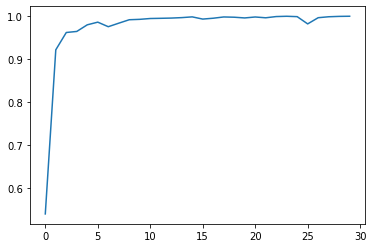

In [14]:
plt.plot(result.history['accuracy'])

In [15]:
result.history['val_accuracy']

[0.9166666865348816,
 0.9725000262260437,
 0.9783333539962769,
 0.9850000143051147,
 0.9850000143051147,
 0.9941666722297668,
 0.9791666865348816,
 0.9950000047683716,
 0.996666669845581,
 0.9933333396911621,
 0.9975000023841858,
 0.996666669845581,
 0.9950000047683716,
 0.996666669845581,
 0.9958333373069763,
 0.9933333396911621,
 0.9983333349227905,
 0.9983333349227905,
 0.9983333349227905,
 0.9983333349227905,
 0.996666669845581,
 0.996666669845581,
 0.9983333349227905,
 0.9975000023841858,
 0.9950000047683716,
 0.9891666769981384,
 0.9991666674613953,
 0.9958333373069763,
 0.9975000023841858,
 0.996666669845581]

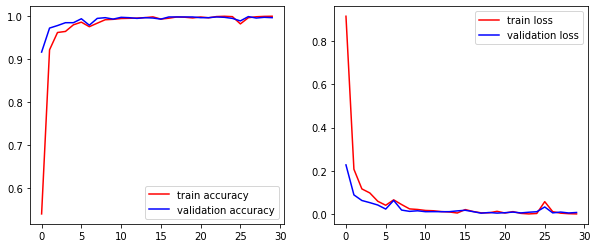

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

plt.plot(result.history['accuracy'], label='train accuracy', color='red')
plt.plot(result.history['val_accuracy'], label='validation accuracy', color='blue')
plt.legend()

plt.subplot(1,2,2)
plt.plot(result.history['loss'], label='train loss', color='red')
plt.plot(result.history['val_loss'], label='validation loss', color='blue')
plt.legend()

plt.show()

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
prediction = model.predict_classes(test_generator)
y_true = test_generator.labels

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [19]:
train_generator.class_indices

{'IncorrectMask': 0, 'WithMask': 1, 'WithoutMask': 2}

In [20]:
confusion_matrix(y_true, prediction)

array([[497,   1,   0],
       [  0, 479,   4],
       [  0,   3, 506]])

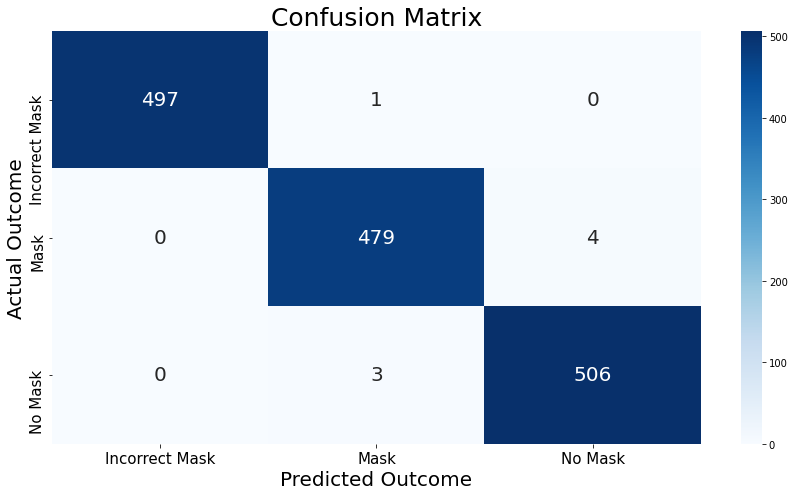

In [21]:
plt.figure(figsize=(35,7))
plt.subplot(131)
ax = sns.heatmap(confusion_matrix(test_generator.labels, prediction.round()),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")
# cmlabels = ['True Negatives', "False Positives",
#                'Flase Negatives', "True Positives"]
# for i,t in enumerate(ax.texts):
#   t.set_text(t.get_text() + "\n" + cmlabels[i])
plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = ['Incorrect Mask', 'Mask', 'No Mask']
ax.set_xticklabels(labels, size=15)
ax.set_yticklabels(labels, size=15)
plt.tight_layout()
plt.show();

In [22]:
print(classification_report(y_true, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       498
           1       0.99      0.99      0.99       483
           2       0.99      0.99      0.99       509

    accuracy                           0.99      1490
   macro avg       0.99      0.99      0.99      1490
weighted avg       0.99      0.99      0.99      1490



In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, prediction)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_true, prediction, average="macro")
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_true, prediction, average="macro")
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, prediction, average="macro")
print('F1 score: %f' % f1)

Accuracy: 0.994631
Precision: 0.994625
Recall: 0.994605
F1 score: 0.994615
